In [117]:


#importing libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torchvision import transforms, models
     

vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
    param.requires_grad_(False)
     


In [118]:


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Cuda Available: ', torch.cuda.is_available())
vgg.to(device)
     


Cuda Available:  True


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [119]:
def load_image(path, max_size=400, shape=None):
    image = Image.open(path).convert('RGB')
    
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    if shape is not None:
        size = shape
    
    in_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image
    

In [120]:
content = load_image('/kaggle/input/imgssgss/Places365_val_00005742.jpg').to(device)

#load style image
style = load_image('/kaggle/input/imgssgss/starry-night.jpg', shape=content.shape[-2:]).to(device)
     

In [121]:
def imconvert(tensor):
    tensor = tensor.cpu().clone().detach()
    tensor = tensor.numpy().squeeze()
    tensor = tensor.transpose(1,2,0)
    tensor = tensor * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    tensor = tensor.clip(0,1)
    return tensor

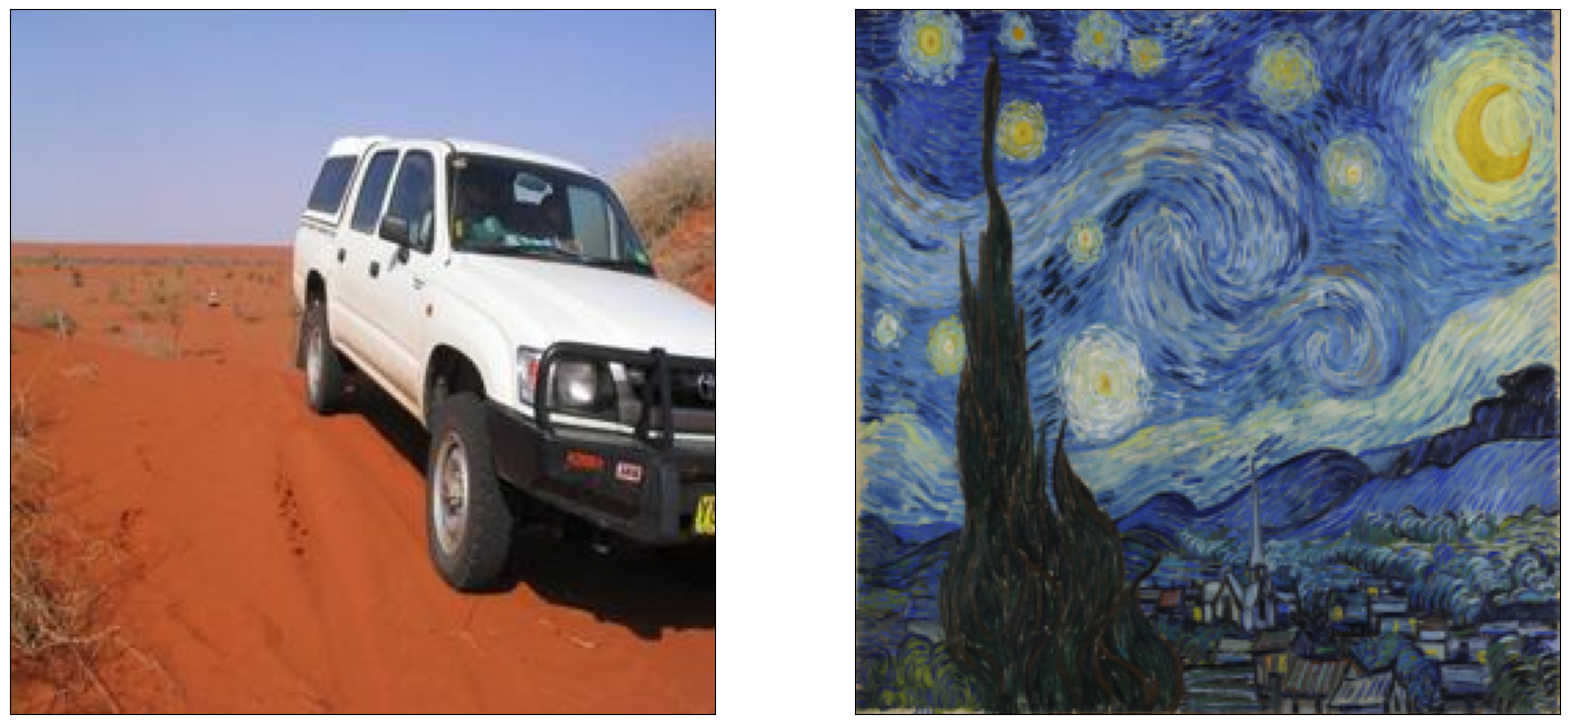

In [122]:


fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,2,1, xticks=[], yticks=[])
ax1.imshow(imconvert(content))
ax2 = fig.add_subplot(1,2,2, xticks=[], yticks=[])
ax2.imshow(imconvert(style))
     


In [123]:


#printing the vgg model
vgg
     


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [124]:


#defining the function to get layers
def get_features(image, model, layers=None):
    if layers is None:
        layers = {'0':'conv1_1','5':'conv2_1', '10':'conv3_1', '19':'conv4_1', '28':'conv5_1', '21':'conv4_2'}
    
    features = {}
    for name, layer in model._modules.items():
        image = layer(image)
        if name in layers:
            features[layers[name]]=image
    
    return features
     


In [125]:
def gram_matrix(tensor):
    batch_size, depth, height, width = tensor.shape
    
    tensor = tensor.view(depth, -1)
    tensor = torch.mm(tensor, tensor.t())
    return tensor

In [126]:
style_features = get_features(style, vgg)
content_features = get_features(content, vgg)

style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

#we could start with random image, but it would be good to start with content image
target = content.clone().requires_grad_(True).to(device)

In [127]:
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.8,
                 'conv3_1': 0.5,
                 'conv4_1': 0.3,
                 'conv5_1': 0.1}


content_weight = 1  # alpha
style_weight = 5e6  # beta

Total Loss:  7.1755571365356445
Total Loss:  3.263486862182617
Total Loss:  1.8847014904022217
Total Loss:  1.239638090133667
Total Loss:  0.8915896415710449
Total Loss:  0.6790337562561035


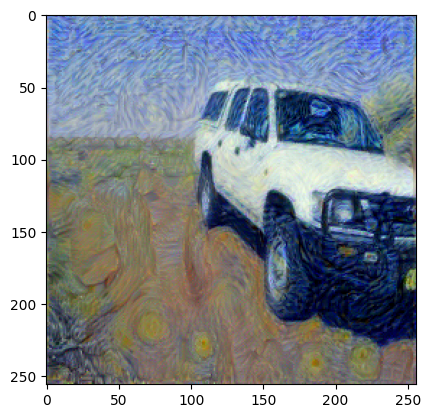

In [128]:
optimizer = torch.optim.Adam([target], lr=0.003)

steps = 2400
print_every = 400

for i in range(1,steps+1):
    
    target_features = get_features(target, vgg)
    content_loss = torch.mean((content_features['conv4_2']-target_features['conv4_2'])**2)
    
    style_loss = 0
    for layer in style_weights:
        
        target_feature = target_features[layer]
        
        _, d, h, w = target_feature.shape
        
        target_gram = gram_matrix(target_feature)
        
        style_gram = style_grams[layer]
        
        layer_style_loss = style_weights[layer]*torch.mean((target_gram - style_gram)**2)
        
        style_loss += layer_style_loss/ (d*h*w)
    
    # total_loss = style_weight*style_loss + content_weight*content_loss
    style_threshold = 1.0
    total_loss = (1 - style_threshold) * content_loss + style_threshold * style_loss
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if i%print_every==0:
        print('Total Loss: ', total_loss.item())
        plt.imshow(imconvert(target))

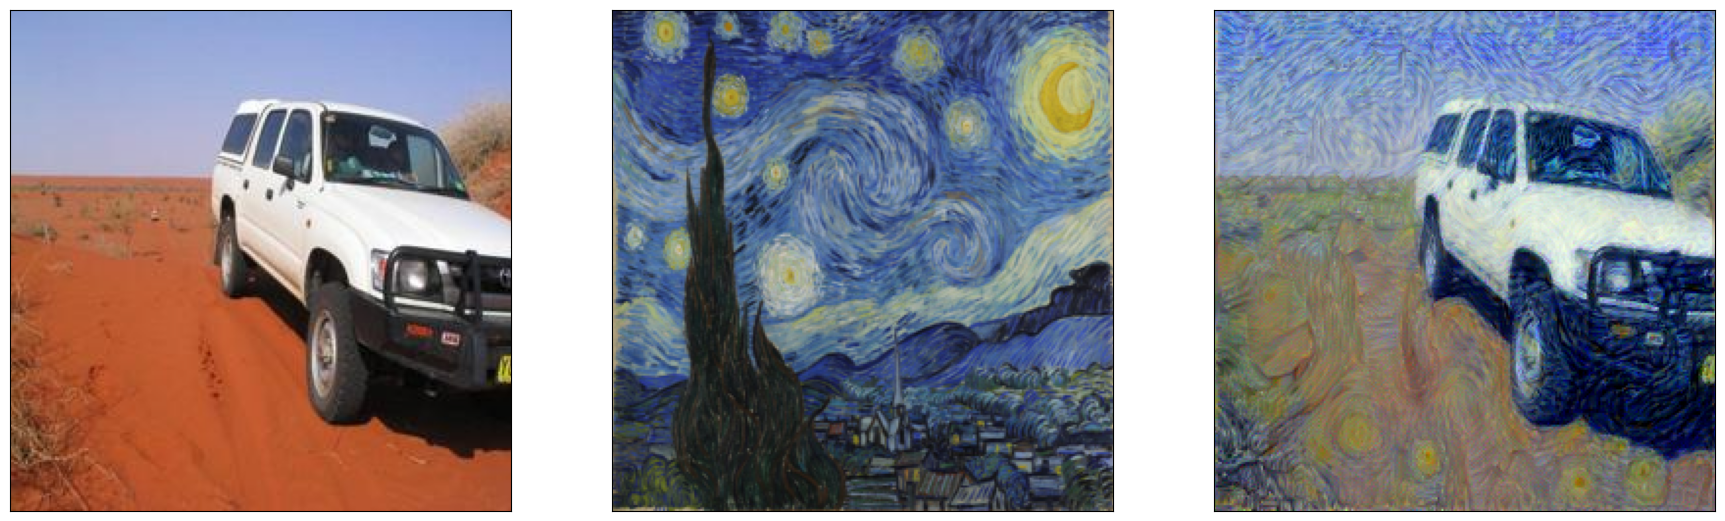

In [129]:
fig = plt.figure(figsize=(22,10))
ax1 = fig.add_subplot(1,3,1, xticks=[], yticks=[])
ax1.imshow(imconvert(content))
ax2 = fig.add_subplot(1,3,2, xticks=[], yticks=[])
ax2.imshow(imconvert(style))

ax3 = fig.add_subplot(1,3,3, xticks=[], yticks=[])
ax3.imshow(imconvert(target))